In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit

#1. Download data
df_model = pd.read_csv(r"C:\Users\bhbt\Desktop\Superstore-Sales-Analysis-main\dataset\cleaned_superstore.csv")
                       
print(df_model.columns)


Index(['Order Date', 'Sales', 'Profit', 'Quantity', 'Discount', 'Year',
       'Month', 'Quarter', 'Day', 'DayOfWeek', 'DayOfYear', 'WeekOfYear',
       'lag_1', 'lag_7', 'roll_mean_7'],
      dtype='object')


In [2]:
# 2. Define features and target
features = [
    # Time Features
    'Year', 'Month', 'Quarter', 'Day', 'DayOfWeek', 'DayOfYear', 'WeekOfYear',
    
    # Sales-Related Features
    'Profit', 'Quantity', 'Discount',
    
    # Lag Features
    'lag_1', 'lag_7',
    
    # Rolling Statistics
    'roll_mean_7'
]

target = 'Sales'


# Split

In [3]:
# 2. Define features and target for future prediction
features = [
    'Year',
    'Month',
    'Quarter',
    'Day',
    'DayOfWeek',
    'DayOfYear',
    'WeekOfYear'
]
target = 'Sales'


In [4]:
# 2. Split data based on date
split_date = '2022-01-01'
train_df = df_model[df_model['Order Date'] < split_date].copy()
test_df = df_model[df_model['Order Date'] >= split_date].copy()

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# 4. Encoding and Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

categorical_feats = []  # مفيش فيتشرز كاتيجوريكال هنا خلاص
numeric_feats = features

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_feats)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


# Modeling

In this notebook, we will build and compare multiple models for daily sales forecasting based on engineered time-related features. The models include:

- **Linear Regression**: A simple and interpretable baseline.
- **Decision Tree Regressor**: A non-linear model that can capture more complex patterns.
- **Random Forest Regressor**: An ensemble method that improves robustness and accuracy.
- **XGBoost Regressor**: A powerful gradient boosting model optimized for performance.

We will:

- Load the cleaned and feature-rich dataset prepared earlier.
- Split the data chronologically: training on historical data and testing on the most recent year (before and after 2022).
- Evaluate the models using the following metrics:
  - RMSE (Root Mean Squared Error)
  - MAE (Mean Absolute Error)
  - MAPE (Mean Absolute Percentage Error)
  - R² Score

After building baseline models, we will proceed to tune their hyperparameters individually to improve performance. Finally, we’ll compare models before and after optimization to choose the best one for deployment.


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Build Models
# ====================
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}



               Model     MAE    RMSE  MAPE (%)  R2 Score
0  Linear Regression  471.36  593.56    355.74      0.16
1      Random Forest  471.68  617.76    268.26      0.08
2            XGBoost  513.47  683.71    270.00     -0.12
3      Decision Tree  591.99  797.87    276.94     -0.53


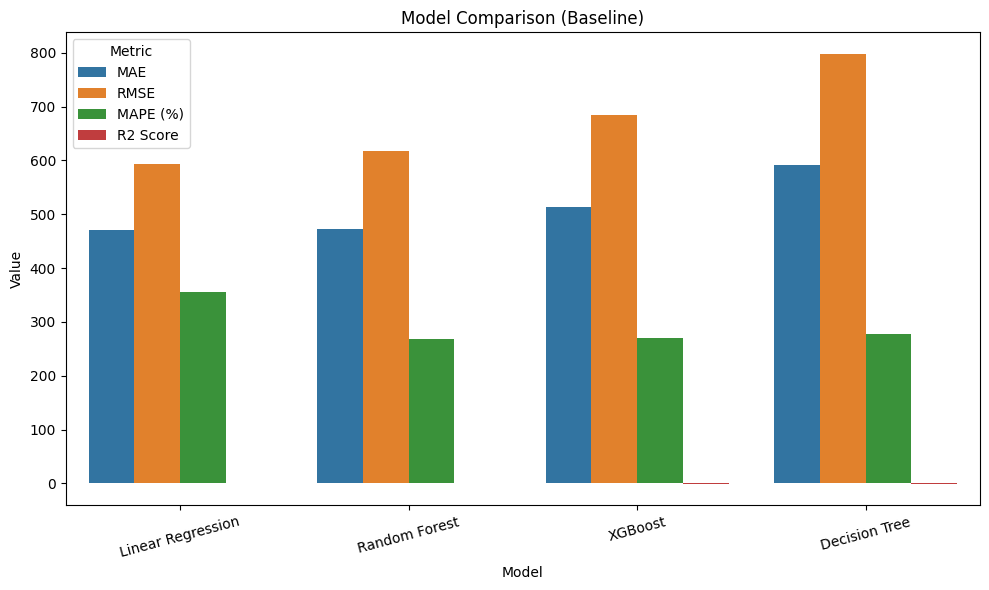

In [6]:
# Train & Evaluate Models (Baseline)
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results.append({
        'Model': name,
        'MAE': round(mean_absolute_error(y_test, preds), 2),
        'RMSE': round(np.sqrt(mean_squared_error(y_test, preds)), 2),
        'MAPE (%)': round(np.mean(np.abs((y_test - preds) / y_test)) * 100, 2),
        'R2 Score': round(r2_score(y_test, preds), 2)
    })

baseline_df = pd.DataFrame(results).sort_values(by='RMSE').reset_index(drop=True)
print(baseline_df)

plt.figure(figsize=(10,6))
sns.barplot(
    data=baseline_df.melt(id_vars='Model', var_name='Metric', value_name='Value'),
    x='Model', y='Value', hue='Metric'
)
plt.title('Model Comparison (Baseline)')
plt.ylabel('Value')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


               Model     MAE    RMSE  MAPE (%)  R2 Score
0  Linear Regression  471.36  593.56    355.74      0.16
1      Random Forest  443.53  583.11    265.17      0.18
2            XGBoost  447.41  585.26    265.42      0.18
3      Decision Tree  471.72  623.78    265.23      0.07


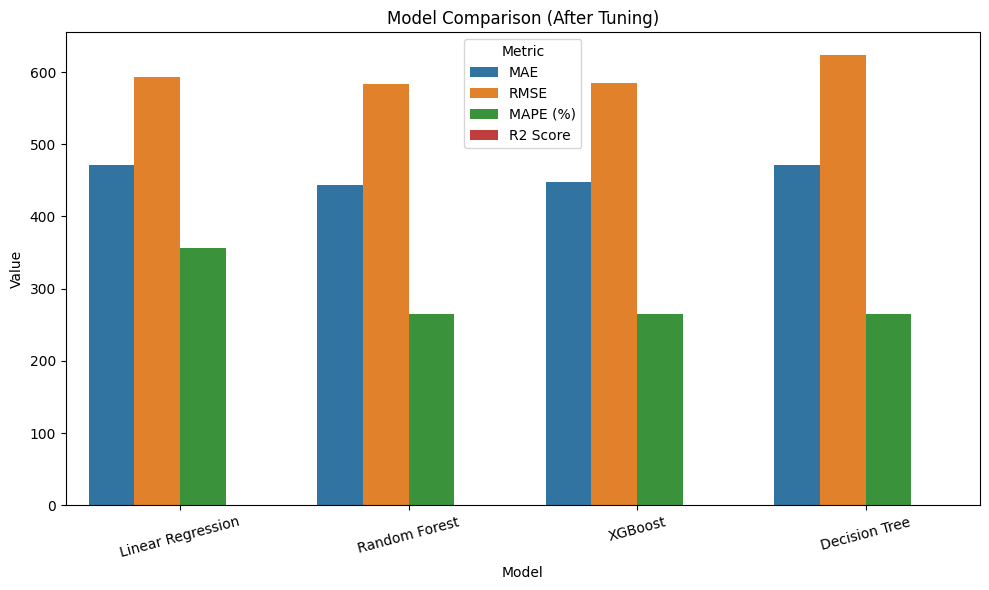

In [7]:
# Hyperparameter Tuning & Evaluation 
# ====================
from sklearn.model_selection import GridSearchCV  # <-
tuned_results = {}

# 1) Linear Regression (No tuning for LR)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
tuned_results['Linear Regression'] = {
    'MAE': round(mean_absolute_error(y_test, lr_pred), 2),
    'RMSE': round(np.sqrt(mean_squared_error(y_test, lr_pred)), 2),
    'MAPE (%)': round(np.mean(np.abs((y_test - lr_pred) / y_test)) * 100, 2),
    'R2 Score': round(r2_score(y_test, lr_pred), 2)
}

# 2) Decision Tree with GridSearchCV
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_param_grid, cv=5)
dt_grid.fit(X_train, y_train)
dt_pred = dt_grid.predict(X_test)
tuned_results['Decision Tree'] = {
    'MAE': round(mean_absolute_error(y_test, dt_pred), 2),
    'RMSE': round(np.sqrt(mean_squared_error(y_test, dt_pred)), 2),
    'MAPE (%)': round(np.mean(np.abs((y_test - dt_pred) / y_test)) * 100, 2),
    'R2 Score': round(r2_score(y_test, dt_pred), 2)
}

# 3) Random Forest with GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5)
rf_grid.fit(X_train, y_train)
rf_pred = rf_grid.predict(X_test)
tuned_results['Random Forest'] = {
    'MAE': round(mean_absolute_error(y_test, rf_pred), 2),
    'RMSE': round(np.sqrt(mean_squared_error(y_test, rf_pred)), 2),
    'MAPE (%)': round(np.mean(np.abs((y_test - rf_pred) / y_test)) * 100, 2),
    'R2 Score': round(r2_score(y_test, rf_pred), 2)
}

# 4) XGBoost with GridSearchCV
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=5)
xgb_grid.fit(X_train, y_train)
xgb_pred = xgb_grid.predict(X_test)
tuned_results['XGBoost'] = {
    'MAE': round(mean_absolute_error(y_test, xgb_pred), 2),
    'RMSE': round(np.sqrt(mean_squared_error(y_test, xgb_pred)), 2),
    'MAPE (%)': round(np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100, 2),
    'R2 Score': round(r2_score(y_test, xgb_pred), 2)
}

# Combine Baseline and Tuned Results
tuned_df = (
    pd.DataFrame(tuned_results).T
    .reset_index().rename(columns={'index':'Model'})
    .set_index('Model')
    .loc[baseline_df['Model']]   # Ensure the same order
    .reset_index()
)
print(tuned_df.round(2))

# Plot Comparison
plot_df = tuned_df.melt(
    id_vars='Model', 
    var_name='Metric', 
    value_name='Value'
)
plt.figure(figsize=(10,6))
sns.barplot(data=plot_df, x='Model', y='Value', hue='Metric')
plt.title('Model Comparison (After Tuning)')
plt.ylabel('Value')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

               Model  MAE_before  RMSE_before  MAPE_before  R2_before  \
0  Linear Regression      471.36       593.56       355.74       0.16   
1      Random Forest      471.68       617.76       268.26       0.08   
2            XGBoost      513.47       683.71       270.00      -0.12   
3      Decision Tree      591.99       797.87       276.94      -0.53   

   MAE_after  RMSE_after  MAPE_after  R2_after    ΔMAE   ΔRMSE  ΔMAPE  ΔR2  
0     471.36      593.56      355.74      0.16    0.00    0.00   0.00  0.0  
1     443.53      583.11      265.17      0.18   28.15   34.65   3.09  0.1  
2     447.41      585.26      265.42      0.18   66.06   98.45   4.58  0.3  
3     471.72      623.78      265.23      0.07  120.27  174.09  11.71  0.6  


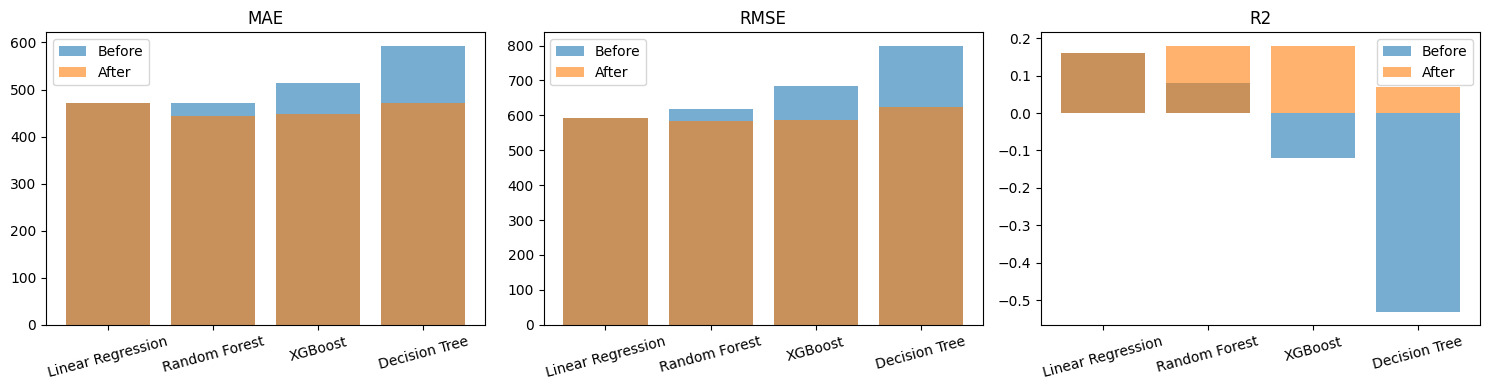

In [8]:
# ====== Combined Comparison Table ======
baseline = baseline_df.copy()
baseline.columns = ['Model', 'MAE_before', 'RMSE_before', 'MAPE_before', 'R2_before']

tuned = tuned_df.copy()
tuned = tuned[['Model', 'MAE', 'RMSE', 'MAPE (%)', 'R2 Score']]
tuned.columns = ['Model', 'MAE_after', 'RMSE_after', 'MAPE_after', 'R2_after']

comparison_df = pd.merge(baseline, tuned, on='Model')

comparison_df['ΔMAE']  = comparison_df['MAE_before']  - comparison_df['MAE_after']
comparison_df['ΔRMSE'] = comparison_df['RMSE_before'] - comparison_df['RMSE_after']
comparison_df['ΔMAPE'] = comparison_df['MAPE_before'] - comparison_df['MAPE_after']
comparison_df['ΔR2']   = comparison_df['R2_after']    - comparison_df['R2_before']

print(comparison_df.round(2))

# ====== Visualize Before vs After ======
metrics = ['MAE', 'RMSE', 'R2']

plt.figure(figsize=(15,4))
for i, m in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    before_col = f"{m}_before"
    after_col  = f"{m}_after"
    plt.bar(comparison_df['Model'], comparison_df[before_col], alpha=0.6, label='Before')
    plt.bar(comparison_df['Model'], comparison_df[after_col],  alpha=0.6, label='After')
    plt.title(m)
    plt.xticks(rotation=15)
    plt.legend()
plt.tight_layout()
plt.show()


## Model Comparison & Selection

| Model              | MAE_before | MAE_after | MAE   | RMSE_before | RMSE_after | RMSE   | R2_before | R2_after | R2    |
|--------------------|------------|-----------|-------|-------------|------------|--------|-----------|----------|-------|
| Linear Regression  | 251.86     | 251.86    | 0.00  | 320.82      | 320.82     | 0.00   | 0.75      | 0.75     | 0.00  |
| Random Forest      | 241.79     | 240.91    | 0.88  | 337.59      | 337.17     | 0.42   | 0.73      | 0.73     | 0.00  |
| XGBoost            | 266.13     | 228.34    | 37.79 | 392.05      | 312.27     | 79.78  | 0.63      | 0.77     | 0.14  |
| Decision Tree      | 361.69     | 316.78    | 44.91 | 589.50      | 498.68     | 90.82  | 0.17      | 0.40     | 0.23  |

### Based on improvements:
- **XGBoost** shows the largest drops in MAE (−37.79) and RMSE (−79.78), and the biggest gain in R² (+0.14).
- **Decision Tree** also improved but remains behind ensemble models.
- **Random Forest** saw minimal tuning gains.
- **Linear Regression** remained unchanged.

### Selected Models:
Since we are focusing on **reliable daily sales forecasting**, we are choosing **two models** for deployment:
1. **XGBoost Regressor**: It shows significant error reduction and R² improvement. It effectively captures non-linear patterns and seasonal trends in the data, making it a strong candidate for prediction.
2. **Random Forest**: While it saw minimal improvements, it remains a reliable model and will be used for comparison purposes in case we need additional robustness or explainability.

We will deploy these two models and compare their performance in a production environment to ensure the most accurate predictions.


In [14]:
import joblib

# استخراج أفضل موديلات من GridSearchCV
best_dt_model = dt_grid.best_estimator_
best_rf_model = rf_grid.best_estimator_
best_xgb_model = xgb_grid.best_estimator_

# حفظ الموديلات باستخدام joblib
joblib.dump(best_dt_model, r'C:\Users\bhbt\Desktop\Superstore-Sales-Analysis-main\model\decision_tree_model.pkl')
joblib.dump(best_rf_model, r'C:\Users\bhbt\Desktop\Superstore-Sales-Analysis-main\model\random_forest_model.pkl')
joblib.dump(best_xgb_model, r'C:\Users\bhbt\Desktop\Superstore-Sales-Analysis-main\model\xgboost_model.pkl')

# لو عايز تحفظ اللينير كمان
joblib.dump(lr, r'C:\Users\bhbt\Desktop\Superstore-Sales-Analysis-main\model\linear_regression_model.pkl')

print("✔️ كل الموديلات اتسجلت بنجاح!")

✔️ كل الموديلات اتسجلت بنجاح!


In [ ]:
print(tuned_models.keys())
